In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Layer:
    __slots__ = [
        # weights 
        "weights",
        "weights_gradient",
        "weights_momentum",
        "weights_gradient_squared",
        "weights_changes",

        # biases
        "biases",
        "biases_gradient",
        "biases_changes",
        "biases_momentum",
        "biases_gradient_squared",

        # activation functions
        "activation",
        "activation_derivative",
    ]

    def __init__(self, nodes_in, nodes_out, activation="sigmoid"):
        self.weights = np.random.normal(size=(nodes_in, nodes_out), scale=1)
        self.biases = np.random.normal(size=(1, nodes_out))
        self.biases_gradient = np.zeros(self.biases.shape)
        self.weights_gradient = np.zeros(self.weights.shape)
        self.biases_changes = np.zeros(self.biases.shape)
        self.weights_changes = np.zeros(self.weights.shape)
        self.biases_momentum = np.zeros(self.biases.shape)
        self.weights_momentum = np.zeros(self.weights.shape)
        self.biases_gradient_squared = np.zeros(self.biases.shape)
        self.weights_gradient_squared = np.zeros(self.weights.shape)

        if activation == "sigmoid":
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation == "linear":
            self.activation = self.linear
            self.activation_derivative = self.linear_derivative

    def calculate_layer(self, input):
        """
        Calculate the output of the layer
        Takes in a numpy array and returns a numpy array
        """
        return self.activation(np.dot(input, self.weights) + self.biases)

    def calculate_layer_and_before_activation(self, input):
        """
        Calculate the output of the layer and the output before the activation function
        Takes in a numpy array and returns a numpy array
        """
        return np.dot(input, self.weights) + self.biases, self.activation(np.dot(input, self.weights) + self.biases)

    def sigmoid(self, x):
        """
        Sigmoid activation function
        Takes in a numpy array and returns a numpy array
        """
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        """
        Sigmoid derivative function
        Takes in a numpy array and returns a numpy array
        """
        return x * (1 - x)

    def linear(self, x):
        """
        Linear activation function
        Takes in a numpy array and returns a numpy array
        """
        return x

    def linear_derivative(self, x):
        """
        Linear derivative function
        Takes in a numpy array and returns a numpy array
        """
        return np.ones_like(x)

    def report_layer(self, layer_num):
        return (
            f"Layer number {layer_num}\nWeights\n{self.weights}\nbiases\n{self.biases}"
        )

    def apply_gradient(self, learning_rate):
        self.weights -= learning_rate * self.weights_gradient
        self.biases -= learning_rate * self.biases_gradient

    def apply_changes(self):
        self.weights += self.weights_changes
        self.biases += self.biases_changes

    def calculate_momentum(self, momentum_decay):
        self.biases_momentum =  momentum_decay * self.biases_momentum + (1 - momentum_decay) * self.biases_gradient
        self.weights_momentum = momentum_decay * self.weights_momentum + (1 - momentum_decay) * self.weights_gradient

    def calculate_gradient_squared(self, decay_rate):
        self.biases_gradient_squared = decay_rate * self.biases_gradient_squared + (1 - decay_rate) * self.biases_gradient ** 2
        self.weights_gradient_squared = decay_rate * self.weights_gradient_squared + (1 - decay_rate) * self.weights_gradient ** 2

    def calculate_changes(self, learning_rate, epsilon, t, momentum_decay, decay_rate):
        self.weights_changes = (- learning_rate / (np.sqrt(self.weights_gradient_squared / (
            1 - decay_rate **t
        )) + epsilon)) * self.weights_momentum / (1 - momentum_decay**t)

        self.biases_changes = (
            - learning_rate / (np.sqrt(self.biases_gradient_squared / (
            1 - decay_rate **t) + epsilon)
        ) * self.biases_momentum / (1 - momentum_decay**t))

In [27]:
class NeuralNetwork:
    __slots__ = ["hidden_layers", "layers"]

    def __init__(self, hidden_layers, input_size, output_size):
        self.hidden_layers = hidden_layers
        self.layers = []

        # Create the input layer
        input_layer = Layer(1, hidden_layers[0])
        self.layers.append(input_layer)

        # Create the hidden layers
        for input_size, output_size in zip(hidden_layers, hidden_layers[1:]):
            self.layers.append(Layer(input_size, output_size))

        # Create the output layer
        output_layer = Layer(hidden_layers[-1], 1, activation="linear")
        self.layers.append(output_layer)

    def forward(self, input):
        """
        Takes a input and returns the output of the network
        """
        for layer in self.layers:
            input = layer.calculate_layer(input)
        return input

    def train(
        self, input, output, learning_rate=0.003, batch_size_frac=0.1, epochs=30000
    ):
        """
        Train the network on a given dataset
        """
        mse_list = []
        for epoch in range(epochs):
            merged = input.to_frame().join(output)
            merged = merged.sample(frac=batch_size_frac)
            self.calculate_gradient(merged["x"], merged["y"])
            self.apply_gradient(learning_rate)
            mse = self.mean_squared_error(merged["x"], merged["y"])
            mse_list.append(mse)
            if epoch % 2000 == 0:
                print(f"Epoch {epoch} MSE: {mse}")
        return mse_list

    def backpropagation(self, input, output):
        """
        Perform backpropagation on the network
        """

        delta_accumulated = [np.zeros_like(layer.biases) for layer in self.layers]
        delta_a_accumulated = [np.zeros_like(layer.weights) for layer in self.layers]
        delta = [np.zeros_like(layer.biases) for layer in self.layers]
        for x,y in zip(input, output):
            # Forward pass
            layers_output = [x]
            layers_values_before_activation = [x]
            for layer in self.layers:
                z, x = layer.calculate_layer_and_before_activation(x)
                layers_output.append(x)
                layers_values_before_activation.append(z)

            # Backward pass

            # Calculate the delta for the output layer
            delta[-1] = self.mean_squared_error_gradient(
                layers_output[-1], y
            ) * self.layers[-1].activation_derivative(
                layers_values_before_activation[-1]
            )

            # Calculate the delta for the hidden layers
            for i in range(2, len(self.layers)):
                delta[-i] = np.dot(
                    delta[-i + 1], self.layers[-i + 1].weights.T
                ) * self.layers[-i].activation_derivative(
                    layers_values_before_activation[-i]
                )
#change grain level
                delta_accumulated = [d + da for d, da in zip(delta, delta_accumulated)]
            try:
                delta_a_accumulated = [0] + [np.dot(layers_output[i-1].T, delta[i]) + da for i, da in enumerate(delta_a_accumulated[1:],1)]
            except AttributeError:
                delta_a_accumulated = [0] + [np.dot(layers_output[i-1], delta[i]) + da for i, da in enumerate(delta_a_accumulated[1:],1)]

        for i, layer in enumerate(self.layers):
            layer.biases_gradient = delta_accumulated[i] / len(input)
            layer.weights_gradient = delta_a_accumulated[i] / len(input)

    def mean_squared_error(self, input, output):
        """
        Calculate the mean squared error of the network on a given dataset and output
        """
        mse = []
        for i, j in zip(input, output):
            mse.append((j - self.forward(i)) ** 2)
        return np.mean(mse)

    def mean_squared_error_gradient(self, predicted, true):
        """
        Calculate the gradient of the mean squared error
        """
        return 2 * (predicted - true)

    def visualize(self):
        """
        Visualize the network architecture
        """
        for i, layer in enumerate(self.layers):
            print(layer.report_layer(i))
            print("\n")

    def apply_gradient(self, learning_rate):
        for layer in self.layers:
            layer.apply_gradient(learning_rate)

    def apply_changes(self):
        for layer in self.layers:
            layer.apply_changes()

    def calculate_momentum(self, momentum_decay):
        for layer in self.layers:
            layer.calculate_momentum(momentum_decay)

    def calculate_gradient_squared(self, decay_rate):
        for layer in self.layers:
            layer.calculate_gradient_squared(decay_rate)

    def calculate_changes(self, learning_rate, epsilon, t, momentum_decay, decay_rate):
        for layer in self.layers:
            layer.calculate_changes(learning_rate, epsilon, t, momentum_decay, decay_rate)

    def calculate_gradient(self, input, output):
        """
        Calculate the gradient of the network
        """
        h = 0.0001
        original_mse = self.mean_squared_error(input, output)

        for layer in self.layers:
            for i in range(layer.weights.shape[0]):
                for j in range(layer.weights.shape[1]):
                    layer.weights[i, j] += h
                    new_mse = self.mean_squared_error(input, output)
                    layer.weights_gradient[i, j] = (new_mse - original_mse) / h
                    layer.weights[i, j] -= h

            for i in range(layer.biases.shape[0]):
                for j in range(layer.biases.shape[1]):
                    layer.biases[i, j] += h
                    new_mse = self.mean_squared_error(input, output)
                    layer.biases_gradient[i, j] = (new_mse - original_mse) / h
                    layer.biases[i, j] -= h

    def adam(
        self,
        X,y,
        learning_rate=0.01,
        momentum_decay=0.9,
        squared_gradient_decay=0.999,
        max_num_epoch=1000,
        batch_size=1,
        batch_fraction=None,
        epsilon=1e-8,
        ):

        # initialization
        if type(X) is pd.DataFrame:
            X = X.to_numpy()
        if type(y) is pd.DataFrame:
            y = y.to_numpy().T
        counter = 0

        # set batch size
        assert type(batch_size) is int, "batch_size must be an integer"
        if batch_fraction is not None:
            assert 0 < batch_fraction <= 1, "batch_fraction must be between 0 and 1"
            batch_size = int(X.shape[0] * batch_fraction)
        iterations = int(X.shape[0] / batch_size)
        mse_list = []

        for i in range(max_num_epoch):
            N = X.shape[0]
            shuffled_idx = np.random.permutation(N)
            # X, y = X[shuffled_idx], y[shuffled_idx]
            for idx in range(iterations):
                X_selected, y_selected = (
                    X[idx * batch_size : (idx + 1) * batch_size],
                    y[idx * batch_size : (idx + 1) * batch_size],
                )
                self.backpropagation(X_selected, y_selected)
                self.calculate_momentum(momentum_decay)
                self.calculate_gradient_squared(squared_gradient_decay)
                counter += 1

                self.calculate_changes(learning_rate, epsilon, counter, momentum_decay, squared_gradient_decay)
                self.apply_changes()
                mse_list.append(self.mean_squared_error(X_selected, y_selected))

            print("Epoch:", i)
        return mse_list

,x,y
1,-0.171543,-127.351580
2,0.025201,-129.942844
3,-1.368991,38.672367
4,1.907390,197.432191
5,0.011129,-129.988852
...,...,...
96,0.529373,-104.778766
97,1.374914,40.134900
98,-1.101985,-20.706642
99,1.175777,-5.579327


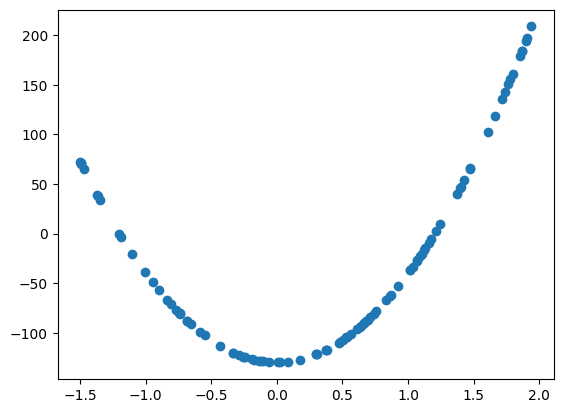

In [158]:
square_simple_train = pd.read_csv("../data/regression/square-simple-training.csv", index_col=0)
square_simple_test = pd.read_csv("../data/regression/square-simple-test.csv", index_col=0)
plt.scatter(square_simple_train["x"], square_simple_train["y"])
square_simple_train

In [39]:
neural = NeuralNetwork([5], 1, 1)
neural.mean_squared_error(square_simple_train["x"], square_simple_train["y"])
mse = neural.train(square_simple_train["x"], square_simple_train["y"], learning_rate=0.001, epochs=16000, batch_size_frac=1)
neural.mean_squared_error(square_simple_test["x"], square_simple_test["y"])

Epoch 0 MSE: 9993.646351666472
Epoch 2000 MSE: 3611.028994064766
Epoch 4000 MSE: 2712.955038818298
Epoch 6000 MSE: 2437.650175485429
Epoch 8000 MSE: 2344.093026758931
Epoch 10000 MSE: 2303.0675660206903
Epoch 12000 MSE: 2129.0152256877445
Epoch 14000 MSE: 697.9366793723692


299.85222873420696

Text(0, 0.5, 'MSE')

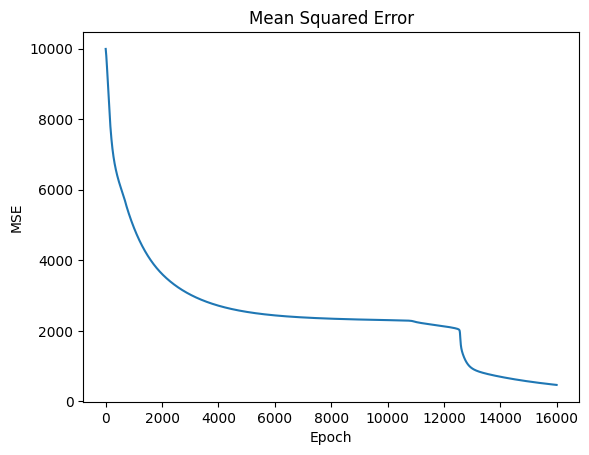

In [40]:
plt.plot(mse)
plt.title("Mean Squared Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")

299.85222873420696

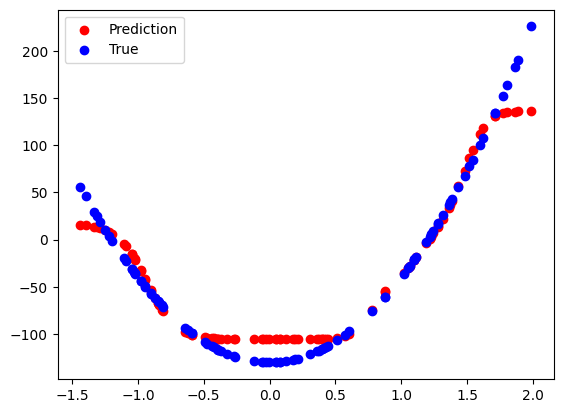

In [41]:
y = []
for i in square_simple_test["x"]:
    y.append(neural.forward(i))
plt.scatter(square_simple_test["x"], y, c="red")
plt.scatter(square_simple_test["x"], square_simple_test["y"], c="blue")
plt.legend(["Prediction", "True"])
neural.mean_squared_error(square_simple_test["x"], square_simple_test["y"])

In [75]:
mean = square_simple_train.mean()
std = square_simple_train.std()
square_simple_train_normalized = (square_simple_train - mean) / std
square_simple_test_normalized = (square_simple_test - mean) / std


In [60]:
neural = NeuralNetwork([5], 1, 1)
neural.mean_squared_error(
    square_simple_train_normalized["x"], square_simple_train_normalized["y"]
)
mse = neural.train(
    square_simple_train_normalized["x"],
    square_simple_train_normalized["y"],
    learning_rate=0.1,
    epochs=8000,
    batch_size_frac=0.2,
)
neural.mean_squared_error(
    square_simple_train_normalized["x"], square_simple_train_normalized["y"]
)

Epoch 0 MSE: 0.8064876699510968
Epoch 2000 MSE: 0.003774789168884792
Epoch 4000 MSE: 0.0005158542372994165
Epoch 6000 MSE: 0.00046346146195215256


0.00036059684528891403

Text(0, 0.5, 'MSE')

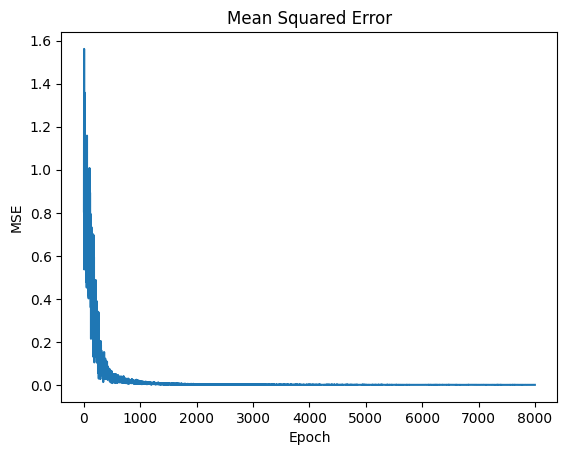

In [61]:
plt.plot(mse)
plt.title("Mean Squared Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")

0.00036059684528891403

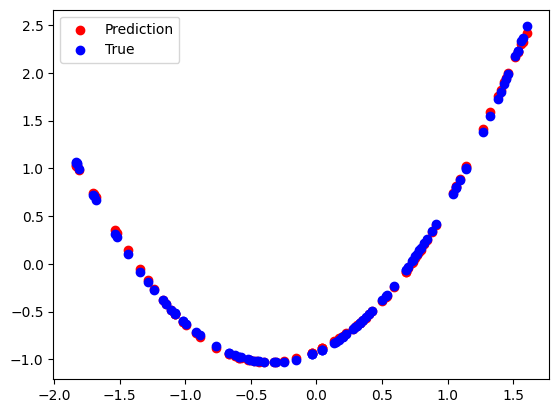

In [62]:
y = []
for i in square_simple_train_normalized["x"]:
    y.append(neural.forward(i))
plt.scatter(square_simple_train_normalized["x"], y, c="red")
plt.scatter(
    square_simple_train_normalized["x"],
    square_simple_train_normalized["y"],
    c="blue",
)
plt.legend(["Prediction", "True"])
neural.mean_squared_error(
    square_simple_train_normalized["x"], square_simple_train_normalized["y"]
)

In [56]:
mse = 0
for x,y in zip(square_simple_test_normalized["x"], square_simple_test_normalized["y"]):
    val = neural.forward(x)
    val = val * std["y"] + mean["y"]
    y = y * std["y"] + mean["y"]
    mse += (val - y) ** 2
print(mse / len(square_simple_test_normalized))
    

[[2.51146756]]


,x,y
1,1.706990,160
2,-0.604580,-80
3,-0.674405,-80
4,1.341562,80
5,-1.427434,-80
...,...,...
996,-1.374447,-80
997,-0.764941,-80
998,-0.304863,0
999,1.681272,160


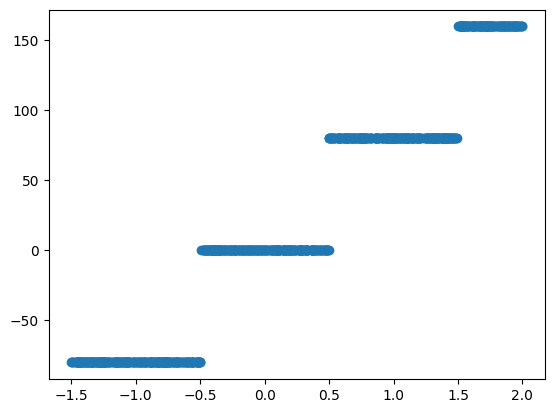

In [8]:
steps_large_train = pd.read_csv("../data/regression/steps-large-test.csv", index_col=0)
steps_large_test = pd.read_csv("../data/regression/steps-large-test.csv", index_col=0)
plt.scatter(steps_large_train["x"], steps_large_train["y"])
steps_large_train

In [25]:
mean = steps_large_train.mean()
std = steps_large_train.std()
steps_large_train_normalized = (steps_large_train - mean) / std
steps_large_test_normalized = (steps_large_test - mean) / std

In [104]:
neural = NeuralNetwork([5,10], 1, 1)
neural.mean_squared_error(
    steps_large_train["x"], steps_large_train["y"]
)
mse = neural.train(
    steps_large_train["x"],
    steps_large_train["y"],
    learning_rate=0.001,
    epochs=1500,
    batch_size_frac=0.2,
)
neural.mean_squared_error(
    steps_large_train["x"], steps_large_train["y"])

Epoch 0 MSE: 6859.504392774565


353.533283106771

Text(0, 0.5, 'MSE')

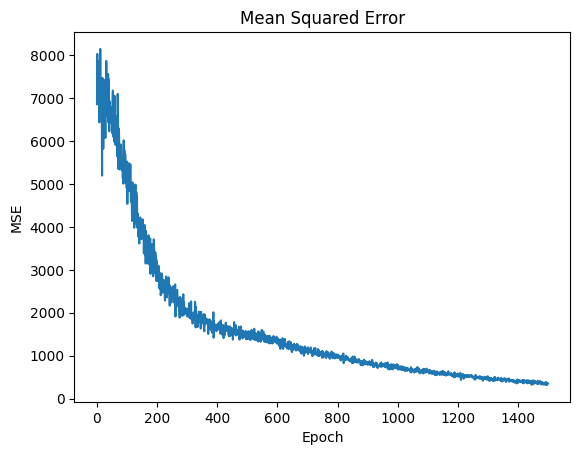

In [105]:
plt.plot(mse)
plt.title("Mean Squared Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")

353.533283106771

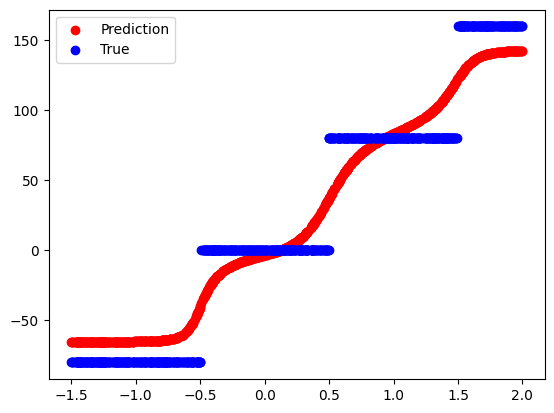

In [106]:
y = []
for i in steps_large_test["x"]:
    y.append(neural.forward(i))
plt.scatter(steps_large_test["x"], y, c="red")
plt.scatter(
    steps_large_test["x"],
    steps_large_test["y"],
    c="blue",
)
plt.legend(["Prediction", "True"])
neural.mean_squared_error(
    steps_large_test["x"], steps_large_test["y"]
)

In [103]:
mse = 0
for x, y in zip(steps_large_test_normalized["x"], steps_large_test_normalized["y"]):
    val = neural.forward(x)
    val = val * std["y"] + mean["y"]
    y = y * std["y"] + mean["y"]
    mse += (val - y) ** 2
print(mse / len(steps_large_test_normalized))

[[24523774.74464002]]


# ADAM

In [70]:
neural = NeuralNetwork([10], 1, 1)
neural.mean_squared_error(
    steps_large_train["x"],
    steps_large_train["y"],
)
mse = neural.adam(
    steps_large_train["x"],
    steps_large_train["y"],
    batch_size=500,
    max_num_epoch=50,
    learning_rate=0.001,
)
neural.mean_squared_error(
    steps_large_train["x"],
    steps_large_train["y"],
)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


7147.435251482427

Text(0, 0.5, 'MSE')

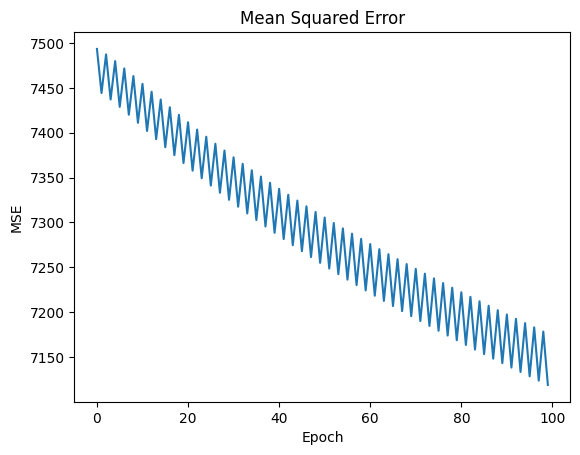

In [71]:
plt.plot(mse)
plt.title("Mean Squared Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")

7147.435251482427

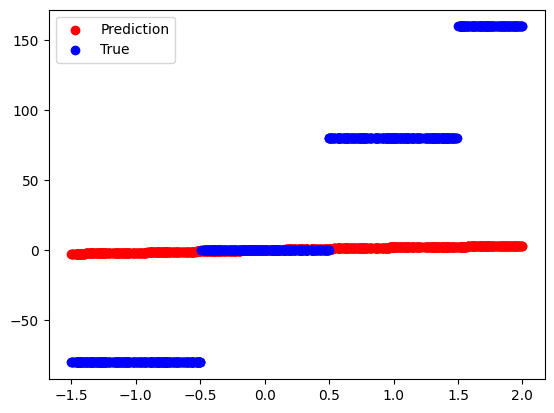

In [72]:
y = []
for i in steps_large_train["x"]:
    y.append(neural.forward(i))
plt.scatter(steps_large_train["x"], y, c="red")
plt.scatter(
    steps_large_train["x"],
    steps_large_train["y"],
    c="blue",
)
plt.legend(["Prediction", "True"])
neural.mean_squared_error(steps_large_train["x"], steps_large_train["y"])

In [96]:
neural = NeuralNetwork([5], 1, 1)
neural.mean_squared_error(
    square_simple_train_normalized["x"], square_simple_train_normalized["y"]
)
mse = neural.adam(
    square_simple_train_normalized["x"],
    square_simple_train_normalized["y"],
    max_num_epoch=100,
    learning_rate=0.1,
    batch_fraction=1,
)
neural.mean_squared_error(
    square_simple_train_normalized["x"], square_simple_train_normalized["y"]
)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99


0.0006719584134324083

Text(0, 0.5, 'MSE')

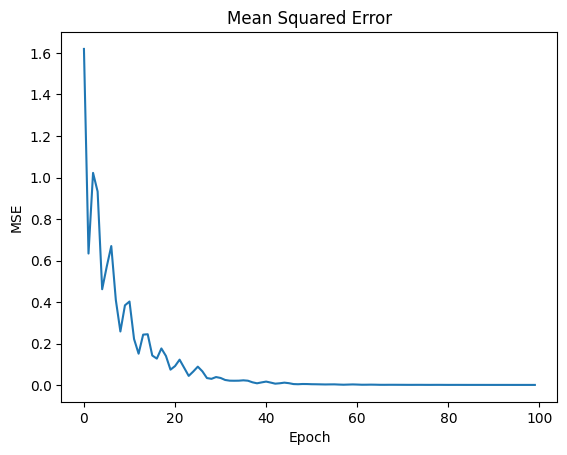

In [97]:
plt.plot(mse)
plt.title("Mean Squared Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")

0.0006719584134324083

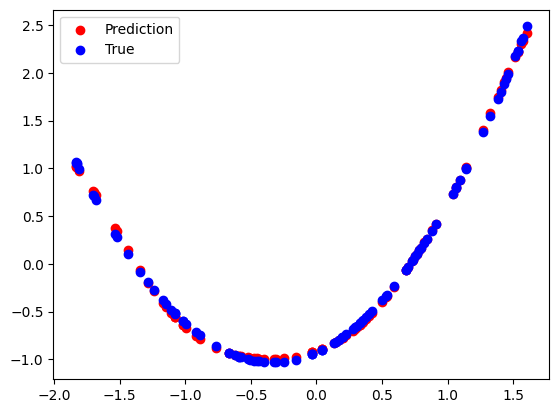

In [98]:
y = []
for i in square_simple_train_normalized["x"]:
    y.append(neural.forward(i))
plt.scatter(square_simple_train_normalized["x"], y, c="red")
plt.scatter(
    square_simple_train_normalized["x"],
    square_simple_train_normalized["y"],
    c="blue",
)
plt.legend(["Prediction", "True"])
neural.mean_squared_error(
    square_simple_train_normalized["x"], square_simple_train_normalized["y"]
)

# multimodal

In [5]:
multimodal_large = pd.read_csv("../data/regression/multimodal-large-test.csv")
multimodal_large

,x,y
0,0.493292,-98.208166
1,-0.470203,-55.283891
2,1.869983,100.299997
3,-1.040446,2.720629
4,-0.616507,-75.991636
...,...,...
995,-0.991285,-1.154110
996,1.122065,100.095817
997,1.193833,99.532882
998,-0.459627,-52.007134


In [6]:
mean = multimodal_large.mean()
std = multimodal_large.std()
multimodal_large_normalized = (multimodal_large - mean) / std

In [179]:
neural = NeuralNetwork([10], 1, 1)
neural.mean_squared_error(
    multimodal_large_normalized["x"],
    multimodal_large_normalized["y"],
)
mse = neural.adam(
    multimodal_large_normalized["x"],
    multimodal_large_normalized["y"],
    batch_size=100,
    max_num_epoch=600,
    learning_rate=0.05,
)
neural.mean_squared_error(
    multimodal_large_normalized["x"],
    multimodal_large_normalized["y"],
)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

0.026843614462298715

Text(0, 0.5, 'MSE')

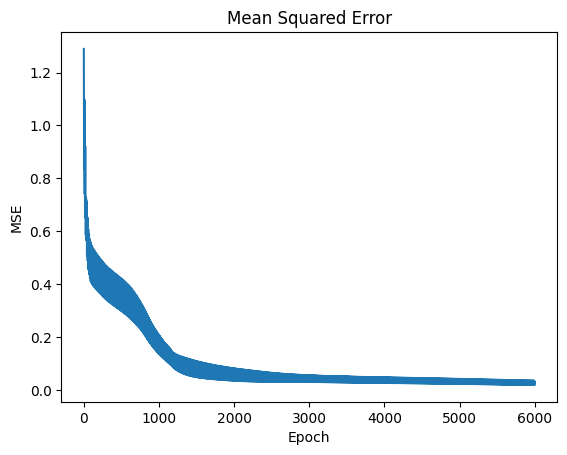

In [180]:
plt.plot(mse)
plt.title("Mean Squared Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")

0.026843614462298715

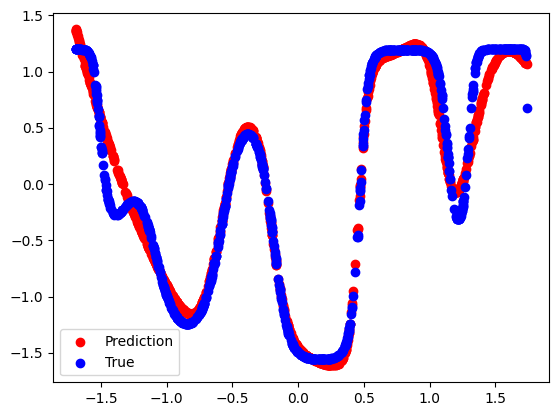

In [181]:
y = []
for i in multimodal_large_normalized["x"]:
    y.append(neural.forward(i))
plt.scatter(multimodal_large_normalized["x"], y, c="red")
plt.scatter(
    multimodal_large_normalized["x"],
    multimodal_large_normalized["y"],
    c="blue",
)
plt.legend(["Prediction", "True"])
neural.mean_squared_error(
    multimodal_large_normalized["x"], multimodal_large_normalized["y"]
)

In [183]:
0.026843614462298715 * std ** 2

x      0.027704
y    140.299494
dtype: float64

In [24]:
neural = NeuralNetwork([10], 1, 1)
neural.mean_squared_error(
    multimodal_large_normalized["x"],
    multimodal_large_normalized["y"],
)
mse = neural.adam(
    multimodal_large_normalized["x"],
    multimodal_large_normalized["y"],
    batch_size=100,
    max_num_epoch=200,
    learning_rate=0.05,
)
neural.mean_squared_error(
    multimodal_large_normalized["x"],
    multimodal_large_normalized["y"],
)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

28524.749831319095

Text(0, 0.5, 'MSE')

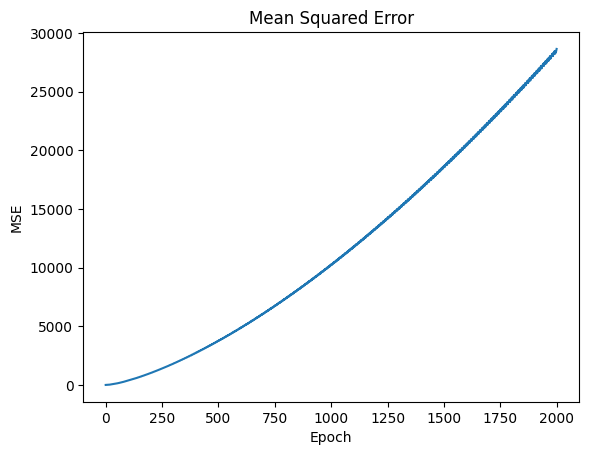

In [25]:
plt.plot(mse)
plt.title("Mean Squared Error")
plt.xlabel("Epoch")
plt.ylabel("MSE")

28524.749831319095

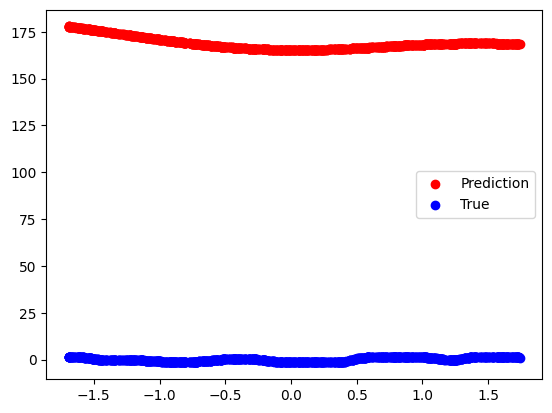

In [26]:
y = []
for i in multimodal_large_normalized["x"]:
    y.append(neural.forward(i))
plt.scatter(multimodal_large_normalized["x"], y, c="red")
plt.scatter(
    multimodal_large_normalized["x"],
    multimodal_large_normalized["y"],
    c="blue",
)
plt.legend(["Prediction", "True"])
neural.mean_squared_error(
    multimodal_large_normalized["x"], multimodal_large_normalized["y"]
)